In [309]:
import numpy as np
from numpy import ndarray
# Process the data
import pandas as pd

import matplotlib.pyplot as plt

plt.style.use("seaborn")

In [334]:
data: pd.DataFrame = pd.read_table("german.data-numeric",
                                   header=None, delim_whitespace=True)

num_cols = data.shape[1]

# Separate features from labels

X_df = data[list(range(num_cols-1))].astype(float)
y_df = data[num_cols-1] - 1  # 0 and 1 instead of 1 and 2
y_df = 2 * y_df - 1

X_df.columns += 1
X_df = (X_df - X_df.mean()) / X_df.std()

X_df.insert(0, 0, 1.)

In [335]:
X_df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1.0,-1.253938,-1.235859,1.343342,-0.733065,1.832252,1.337409,0.449102,1.046463,-1.293076,...,-0.195916,-0.552429,-0.338692,0.320052,-0.206664,-0.4667,0.634131,-0.149908,-0.49975,0.765973
1,1.0,-0.458797,2.247070,-0.503176,0.965893,-0.699357,-0.317800,-0.963168,-0.765594,-1.293076,...,-0.195916,-0.552429,-0.338692,0.320052,-0.206664,-0.4667,0.634131,-0.149908,-0.49975,0.765973
2,1.0,1.131486,-0.738298,1.343342,-0.414510,-0.699357,0.509805,0.449102,0.140434,-1.293076,...,-0.195916,-0.552429,-0.338692,0.320052,-0.206664,-0.4667,0.634131,-0.149908,1.99900,-1.304224
3,1.0,-1.253938,1.749509,-0.503176,1.638398,-0.699357,0.509805,0.449102,1.046463,-0.340885,...,-0.195916,-0.552429,-0.338692,-3.121368,-0.206664,-0.4667,-1.575384,-0.149908,-0.49975,0.765973
4,1.0,-1.253938,0.256825,0.420083,0.576549,-0.699357,-0.317800,0.449102,1.046463,1.563498,...,-0.195916,1.808378,-0.338692,0.320052,-0.206664,-0.4667,-1.575384,-0.149908,-0.49975,0.765973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,1.131486,-0.738298,-0.503176,-0.556090,-0.699357,0.509805,-0.963168,1.046463,-1.293076,...,-0.195916,-0.552429,-0.338692,0.320052,-0.206664,-0.4667,0.634131,-0.149908,1.99900,-1.304224
996,1.0,-1.253938,0.754386,-0.503176,0.222599,-0.699357,-0.317800,-2.375438,1.046463,-0.340885,...,-0.195916,-0.552429,2.949581,0.320052,-0.206664,-0.4667,0.634131,-0.149908,-0.49975,-1.304224
997,1.0,1.131486,-0.738298,-0.503176,-0.874645,-0.699357,1.337409,0.449102,1.046463,0.611307,...,-0.195916,-0.552429,-0.338692,0.320052,-0.206664,-0.4667,0.634131,-0.149908,-0.49975,0.765973
998,1.0,-1.253938,1.998289,-0.503176,-0.520695,-0.699357,-0.317800,0.449102,1.046463,1.563498,...,-0.195916,-0.552429,-0.338692,0.320052,-0.206664,-0.4667,-1.575384,-0.149908,-0.49975,0.765973


As demonstrated in the report, Gibbs sampling now boils down to the loop:
* sample $\beta^{t+1} \sim p(\beta|z^t) = \mathcal N(\mu^t, \Sigma)$ where
$$
    W = \Sigma^{-1} = \frac1\tau I_p + X^TX,
    \quad
    \mu^t = \Sigma X^Tz^t \in \mathbb R^p
$$
* sample $z^{t+1} \sim p(z|\beta^{t+1},y) = \exp(-\frac12\|z-X\beta\|^2) \prod_i \mathbf{1}_{\{y_iz_i > 0\}}$

In [336]:
import scipy as sp
import scipy.linalg as splin
from scipy.stats import truncnorm

In [337]:
def sample_truncated_gaussian(mean, y, size=None):
    """
    Sample a vector of truncated Gaussians z with means
    mean[i] and in the support z[i]y[i] > 0.
    """
    dim = len(mean)
    a = np.zeros((dim,))
    b = np.zeros((dim,))
    a[y < 0] = -np.inf
    b[y > 0] = np.inf
    if size is not None:
        size = (size, dim)
    z = truncnorm.rvs(a, b, loc=mean, size=size)
    return z

In [338]:
sample_truncated_gaussian(
    np.zeros((2,)), y=np.array([-1, 1]))

array([-1.08853939,  0.84966012])

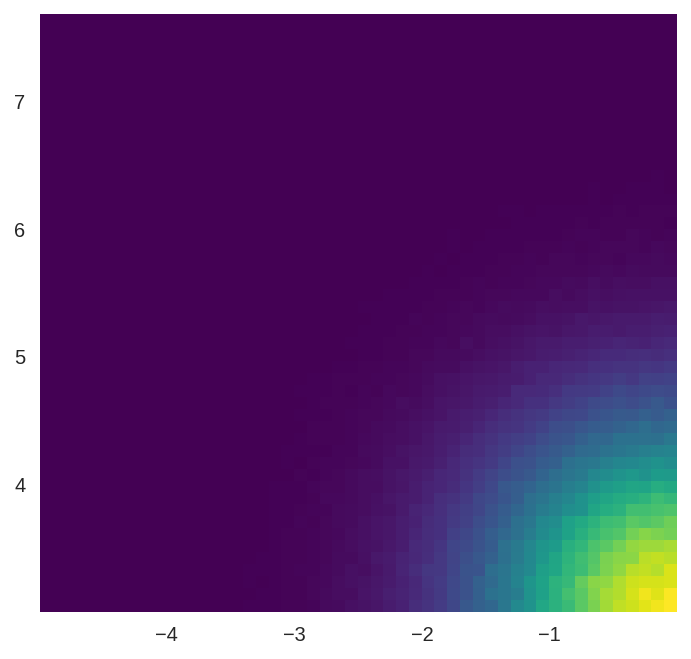

In [418]:
z_s = sample_truncated_gaussian(
    np.array([0., 3.]), y=np.array([-1, 1]), size=600000)
z_s.shape

plt.hist2d(*z_s.T, bins=50, cmap=plt.cm.viridis);
plt.axis('scaled');

In [393]:
def gibbs_sampler(X: ndarray, y: ndarray, tau=100, num_its=8000, burn_in=4000):
    """
    Gibbs sampler for the graphical model.
    """
    n = X.shape[0]
    d = X.shape[1]
    
    # posterior beta|z precision matrix
    prec_ = 1./tau * np.eye(d) + X.T @ X  # shape (d, d)
    cov_ = splin.pinvh(prec_)  # covariance matrix
    xtx = X.T @ X
    print("Cov matrix:", cov_.shape)
    mu_mat = cov_ @ X.T  # apply to update mu_t, never need to update
    # mu_mat = cov_ @ xtx
    
    z = np.zeros((n,))
    
    mu_s = []
    z_s = np.zeros((num_its-burn_in, n))
    betas = np.zeros((num_its-burn_in, d))
    
    for t in range(num_its):
        ## Update posterior parameters
        # beta_hat, *_ = np.linalg.lstsq(X, z)
        # mu = mu_mat @ beta_hat
        mu = mu_mat @ z
        
        ## Sample beta|z
        beta = np.random.multivariate_normal(mu, cov_)
        
        ## Sample z|beta,y
        postmean = X @ beta
        z = sample_truncated_gaussian(mean=postmean, y=y)  # shape (n,)
        
        
        if t >= burn_in:
            mu_s.append(mu)
            betas[t-burn_in, :] = beta
            z_s[t-burn_in, :] = z
        
    return betas, z_s, np.array(mu_s)

In [394]:
betas, z_s, mu_s = gibbs_sampler(X_df.values, y_df.values,
                                 tau=100, num_its=1500, burn_in=500)

Cov matrix: (25, 25)


## Trace plots

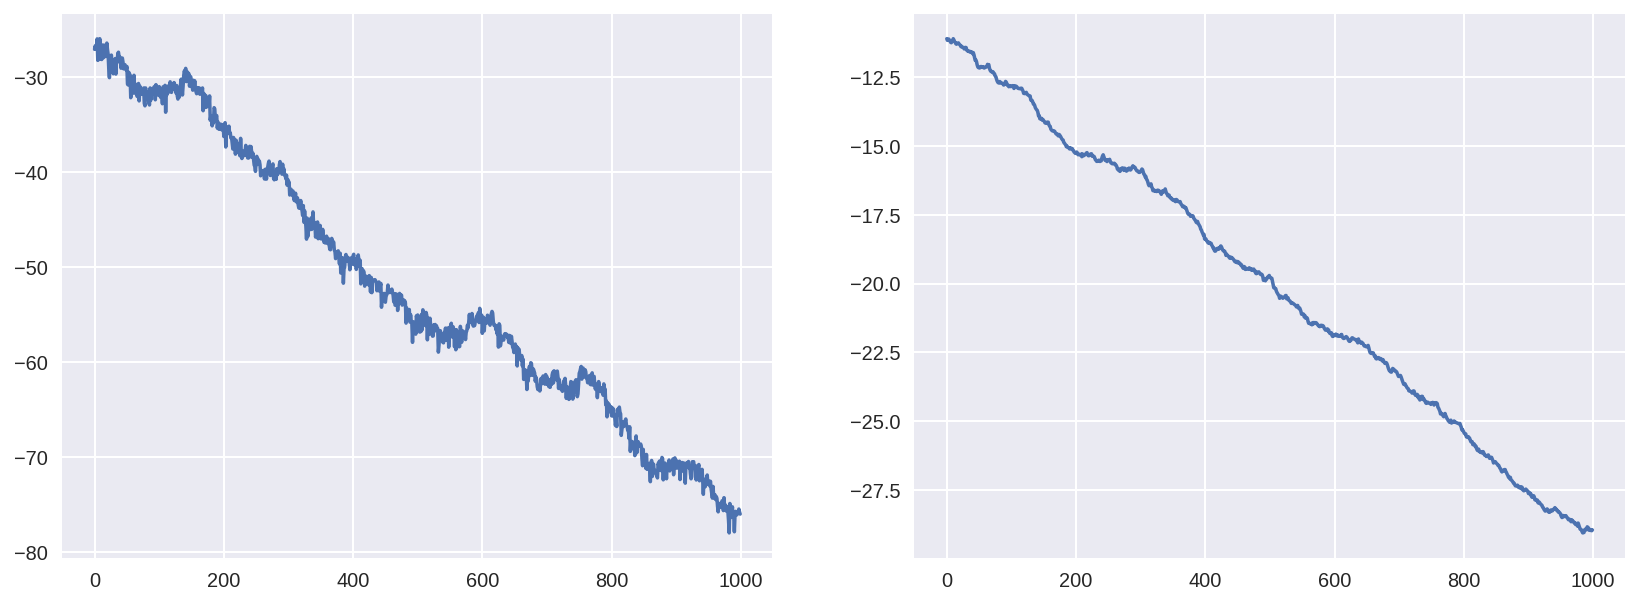

In [396]:
fig = plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.plot(np.arange(z_s.shape[0]), z_s[:, 3])

plt.subplot(122)
plt.plot(np.arange(betas.shape[0]), betas[:, 10]);